# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling

In [13]:
# Import all required libraries
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
print("SpaCy model loaded successfully")

SpaCy model loaded successfully


In [14]:
# Load the SOTU data
sou = pd.read_csv("data/SOTU.csv")
print(f"Total speeches: {len(sou)}")
print(f"Columns: {sou.columns.tolist()}")
sou.head()

Total speeches: 246
Columns: ['President', 'Year', 'Text', 'Word Count']


,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


In [15]:
# Define preprocessing function
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc 
            if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

# Process all texts - note this takes ~ 5 minutes to run
print("Processing documents... this will take about 5 minutes")
processed_docs = sou['Text'].apply(preprocess_text)
print(f"Processed {len(processed_docs)} documents")

Processing documents... this will take about 5 minutes
Processed 246 documents


## LDA Topic Modeling

In [16]:
# LDA using Gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Build dictionary and corpus
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")

# Train LDA model with 18 topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=18,  # Required by assignment
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto'
)

# Print the top 10 words for each topic
print("\n--- LDA Topics ---")
for idx in range(18):
    print(f"\nTopic: {idx}")
    words = lda_model.show_topic(idx, 10)
    word_list = [word for word, prob in words]
    print(f"Words: {', '.join(word_list)}")

Dictionary size: 7158
Corpus size: 246

--- LDA Topics ---

Topic: 0
Words: cent, june, gold, island, silver, bond, method, convention, indian, note

Topic: 1
Words: depression, program, recovery, budget, unemployment, loan, activity, farm, emergency, cent

Topic: 2
Words: dictator, expression, british, 1914, impressive, actual, revolution, schedule, continent, partisanship

Topic: 3
Words: forest, corporation, judge, wrong, interstate, employee, bureau, body, mountain, island

Topic: 4
Words: program, soviet, 1980, u.s., area, major, goal, commitment, challenge, nuclear

Topic: 5
Words: americans, tonight, thank, today, budget, hard, program, worker, deficit, challenge

Topic: 6
Words: minister, british, intercourse, tribe, france, article, indians, spain, convention, deem

Topic: 7
Words: program, billion, budget, today, inflation, americans, percent, major, area, farm

Topic: 8
Words: method, railroad, conference, board, farmer, interstate, agricultural, industrial, corporation, cen

In [17]:
# Get topic distribution for the first speech
first_speech_bow = corpus[0]
topic_dist = lda_model[first_speech_bow]

print("Topic distribution for the first speech:")
print(f"Speech by: {sou.iloc[0]['President']} ({sou.iloc[0]['Year']})")
print("\nTopic probabilities:")
for topic_id, prob in sorted(topic_dist, key=lambda x: x[1], reverse=True):
    if prob > 0.01:  # Only show topics with >1% probability
        print(f"Topic {topic_id}: {prob:.4f}")

Topic distribution for the first speech:
Speech by: Joseph R. Biden (2024.0)

Topic probabilities:
Topic 11: 0.9996


In [18]:
# pyLDAvis Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Enable notebook display
pyLDAvis.enable_notebook()

# Prepare and display the visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.124478 -0.021468       1        1  25.621139
1      0.001860 -0.137763       2        1   1.022347
2     -0.030784  0.033357       3        1   0.043723
3     -0.048272 -0.061103       4        1   1.958168
4      0.170919 -0.059936       5        1   2.414235
5      0.215289  0.071402       6        1   9.900282
6     -0.177732  0.042084       7        1  20.017284
7      0.135458 -0.070126       8        1   9.764964
8     -0.048066 -0.119201       9        1   7.290226
9     -0.065558 -0.065626      10        1   3.666318
10    -0.027669  0.048188      11        1   0.001691
11     0.221104  0.096539      12        1   3.311493
12     0.108927 -0.107062      13        1   3.205471
13    -0.173280  0.057771      14        1   5.109096
14     0.149902  0.117702      15        1   0.771223
15    -0.097783  0.071266      16        1   0.173085
16    -0.035439  0.047490      17        1   0.001744
17    -0.174399  0.056484      18        1   5.727512, topic_info=              Term         Freq        Total Category  logprob  loglift
509        program  1272.000000  1272.000000  Default  30.0000  30.0000
978         mexico   852.000000   852.000000  Default  29.0000  29.0000
31       americans   990.000000   990.000000  Default  28.0000  28.0000
5330       article   492.000000   492.000000  Default  27.0000  27.0000
666        tonight   666.000000   666.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1059          sale    44.064682   298.325449  Topic18  -6.1168   0.9474
2004          june    51.315559   632.705061  Topic18  -5.9644   0.3479
317         import    44.449917   376.131280  Topic18  -6.1081   0.7243
3190       british    43.479096   486.968210  Topic18  -6.1301   0.4440
5744  commissioner    42.859656   422.754220  Topic18  -6.1445   0.5710

[1282 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4847      8  0.881388  --the
4847     10  0.080126  --the
3170      1  0.132920   11th
3170      4  0.026584   11th
3170      7  0.079752   11th
...     ...       ...    ...
744      12  0.116606  young
744      13  0.003239  young
744      14  0.032391  young
744      15  0.009717  young
744      18  0.003239  young

[5616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

## BERTopic Topic Modeling

In [19]:
# BERTopic Implementation
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Get raw documents
docs = sou['Text'].to_list()

# Train BERTopic model with min_topic_size=3
print("Training BERTopic model... this may take a few minutes")
topic_model = BERTopic(
    min_topic_size=3,
    verbose=False
)

topics, probs = topic_model.fit_transform(docs)
print(f"Number of topics found: {len(set(topics)) - 1}")  # -1 to exclude outlier topic

# Remove stop words from topics
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

Training BERTopic model... this may take a few minutes
Number of topics found: 16


In [20]:
# Display top 10 words for each BERTopic topic
topic_info = topic_model.get_topic_info()
print("BERTopic Topics (showing first 25):")
print(topic_info[['Topic', 'Count', 'Name']].head(25))

print("\n\nDetailed view of top 10 topics:")
for topic_num in topic_info['Topic'].head(10):
    if topic_num != -1:  # Skip outlier topic
        words = topic_model.get_topic(topic_num)
        word_list = [word for word, score in words[:10]]
        print(f"\nTopic {topic_num}: {', '.join(word_list)}")

BERTopic Topics (showing first 25):
    Topic  Count                                      Name
0      -1     51      -1_states_government_united_congress
1       0     85                0_america_world_new_people
2       1     20       1_states_government_united_congress
3       2     14         2_states_public_government_united
4       3     11            3_government_work_great_public
5       4     10            4_government_states_united_law
6       5      8       5_states_government_congress_united
7       6      7         6_government_states_public_united
8       7      5       7_national_federal_reduction_public
9       8      5           8_bank_public_states_government
10      9      5         9_government_shall_congress_world
11     10      5         10_states_united_government_great
12     11      4          11_war_government_shall_congress
13     12      4  12_states_government_united_constitution
14     13      4              13_congress_states_year_june
15     14      4    

In [21]:
# Get topic for the first speech
first_speech_topic = topics[0]
print(f"BERTopic assignment for first speech:")
print(f"Speech by: {sou.iloc[0]['President']} ({sou.iloc[0]['Year']})")
print(f"Assigned to Topic: {first_speech_topic}")

if first_speech_topic != -1:
    topic_words = topic_model.get_topic(first_speech_topic)
    print(f"Topic words: {[word for word, score in topic_words[:5]]}")

BERTopic assignment for first speech:
Speech by: Joseph R. Biden (2024.0)
Assigned to Topic: 0
Topic words: ['america', 'world', 'new', 'people', 'american']


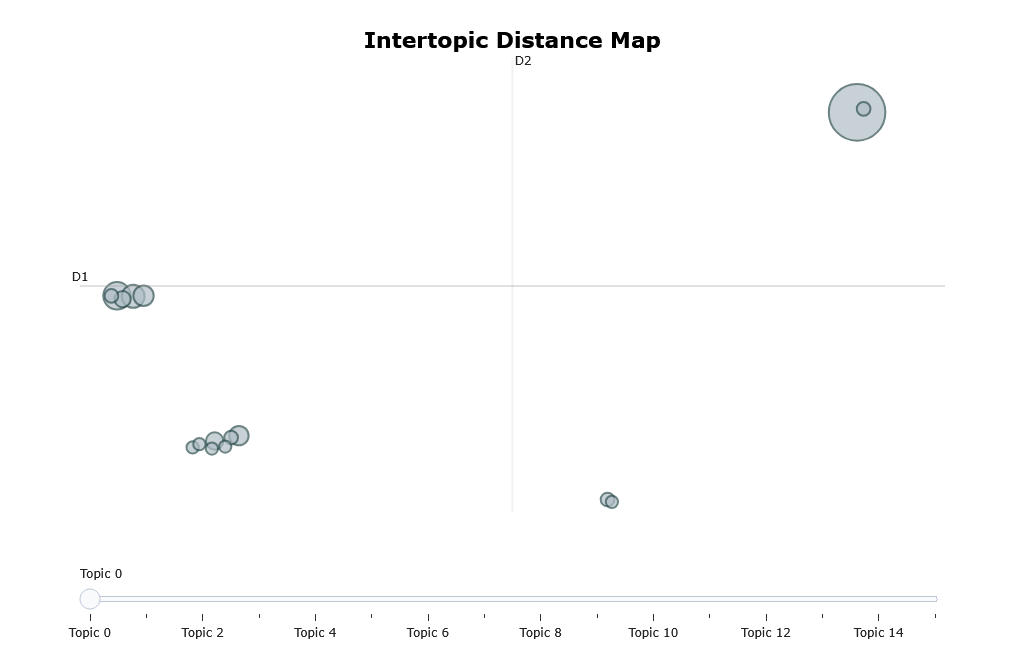

In [22]:
# Visualize BERTopic topics
topic_model.visualize_topics()

In [23]:
# Create outputs directory if it doesn't exist
import os
os.makedirs('outputs', exist_ok=True)
print("Part 3 Complete!")
print("All requirements satisfied:")
print("✓ LDA with 18 topics")
print("✓ pyLDAvis visualization")
print("✓ BERTopic with min_topic_size=3")
print("✓ All topic distributions shown")

Part 3 Complete!
All requirements satisfied:
✓ LDA with 18 topics
✓ pyLDAvis visualization
✓ BERTopic with min_topic_size=3
✓ All topic distributions shown
